# The Bridge Game

The glass bridge is a game in the [Netflix](https://netflix.com/) series [The Squid Game](https://www.imdb.com/title/tt10919420/). The series is Netflix's most-watched series to date, becoming the top-viewed program in 94 countries and attracting more than 142 million member households during its first four weeks from launch. (Source [Wikipedia](https://en.wikipedia.org/wiki/Squid_Game))

**Spoiler Alert** Don't read the article if you intend to watch the series!

![Squid Game Copyright Netflix 2021](squid_game_poster.png){: .center}

<p align="center">
<i><a href="https://www.netflix.com/de/title/81040344">Squid Game</a> - © Netflix 2021</i>
</p>


In one scene in Episode 7, 16 players have to cross a bridge made of two rows of glass tiles. The bridge is 18 steps long. They have to jump to one tile per row, but just one will last whereas the other one is made of tempered glass, which breaks under impact. The players start in an ordered fashion, whereby players with higher numbers will avoid broken tiles. To penalize players with higher numbers, there is a time-limit after which players which have not passed the bridge have lost as well (and pay with their lives).

**Disclaimer** The author considers the game purely from a scientific/fictional perspective. The game as well as  the concept of the series are immoral, wrong, and detestable.

![Squid Game Copyright Netflix 2021](squid_game_bridge_scene.png){: .center}

<p align="center">
<i><a href="https://www.netflix.com/de/title/81040344">Squid Game</a> - © Netflix 2021</i>
</p>


Inspired by another [simulation](https://www.jhelvy.com/posts/2021-10-19-monte-carlo-bridge-game/) this example illustrates how to run simulations in different configurations many times to work out process parameters. Here, the key parameter of interest is the **number of surviving players**.

As players in the show, can pick their start number, the episode and also the internet community circles around the question regarding an optimal start number to _optimize the chance of survival_.

At its heart - which is its [process definition](../component.md#creation-of-a-component) -  it is a very simplistic model that centers around simulating the participants stepping on the tiles one after another, while considering the _learning experience_ of earlier participants with lower start numbers.


In [24]:
@file:Repository("*mavenLocal")
@file:DependsOn("com.github.holgerbrandl:kalasim:0.7-SNAPSHOT")

//@file:DependsOn("com.github.holgerbrandl:kalasim:0.6.91")
@file:DependsOn("com.github.holgerbrandl:kravis:0.8.1")

In [67]:
import org.kalasim.*

import kravis.geomBar
import kravis.geomCol
import kravis.plot
import org.apache.commons.math3.distribution.LogNormalDistribution

import java.lang.Double.min
import kotlin.random.Random

In [72]:
//LogNormalDistribution(3.5, 0.88).let{ dist ->
//    repeat(100){ println(dist.sample())}
//}



In [83]:
//todo set random seed
class SquidGame(
    val numSteps: Int = 18,
    val numPlayers: Int = 16,
    val maxDuration: Int = 12 * 60
) : Environment(randomSeed =Random.nextInt()) {

    // randomization
    val stepTime = LogNormalDistribution(rg, 3.5, 0.88)
//    val stepTime = uniform(10,30)

    val decision = enumerated(true, false)

    // state
    var stepsLeft = numSteps
    var survivors= mutableListOf<Int>()

    val numTrials: Int
        get() = numSteps - survivors.size

    val numSurvivors : Int
       get() = survivors.size

    fun playerSurvived(playerNo: Int) = survivors.contains(playerNo)

    init {
        object : Component() {
            override fun process() = sequence {
               queue@
               for(player in 1..numPlayers){
                   // todo this is not correct, as steps themselfes take time
                    hold(min(stepTime(), 100.0)) // cap time at 100sec

                    while(stepsLeft-- > 0){
                        if(decision()) continue@queue
                    }

                    survivors.add(player)

                    if(now > maxDuration) break
                }
            }
        }
    }
}

Move times are modelled using a log-normal distribution with the parameters from [here](https://www.jhelvy.com/posts/2021-10-19-monte-carlo-bridge-game/). Similar to the previous work, we cap the time it takes a player to make a move (or just part of it) at 100 seconds.

To get started, we can simply run the simulation with

In [84]:
val sim = SquidGame()
sim.run()

println("${sim.numSurvivors} survived")

5 survived


In [85]:
sim.playerSurvived(13)

true

Did a sensible range of the players survive? We'd expect players in the range between 8-13 to survive most likely

In [86]:
(1..18).map{ sim.playerSurvived(it)}

[false, false, false, false, false, false, false, false, false, false, false, true, true, true, true, true]

The model seems fine at first glance. In particular the impact of timing becomes visible, as the last player did not survive the game

Some players survived the game. But clearly, running it once, does not tell much about  the average number of survivors. So we run it many times, and visualize the distribution.


In [87]:
val manyGames = org.kalasim.misc.repeat(10000) {
    SquidGame().apply { run() }
}

val avgSurvivors = manyGames.map { it.numSurvivors }.average()
println("The average number of survivors is ${avgSurvivors}")

The average number of survivors is 6.54


Now since we have sampled the process, we can also easily visualize the survival count distribution

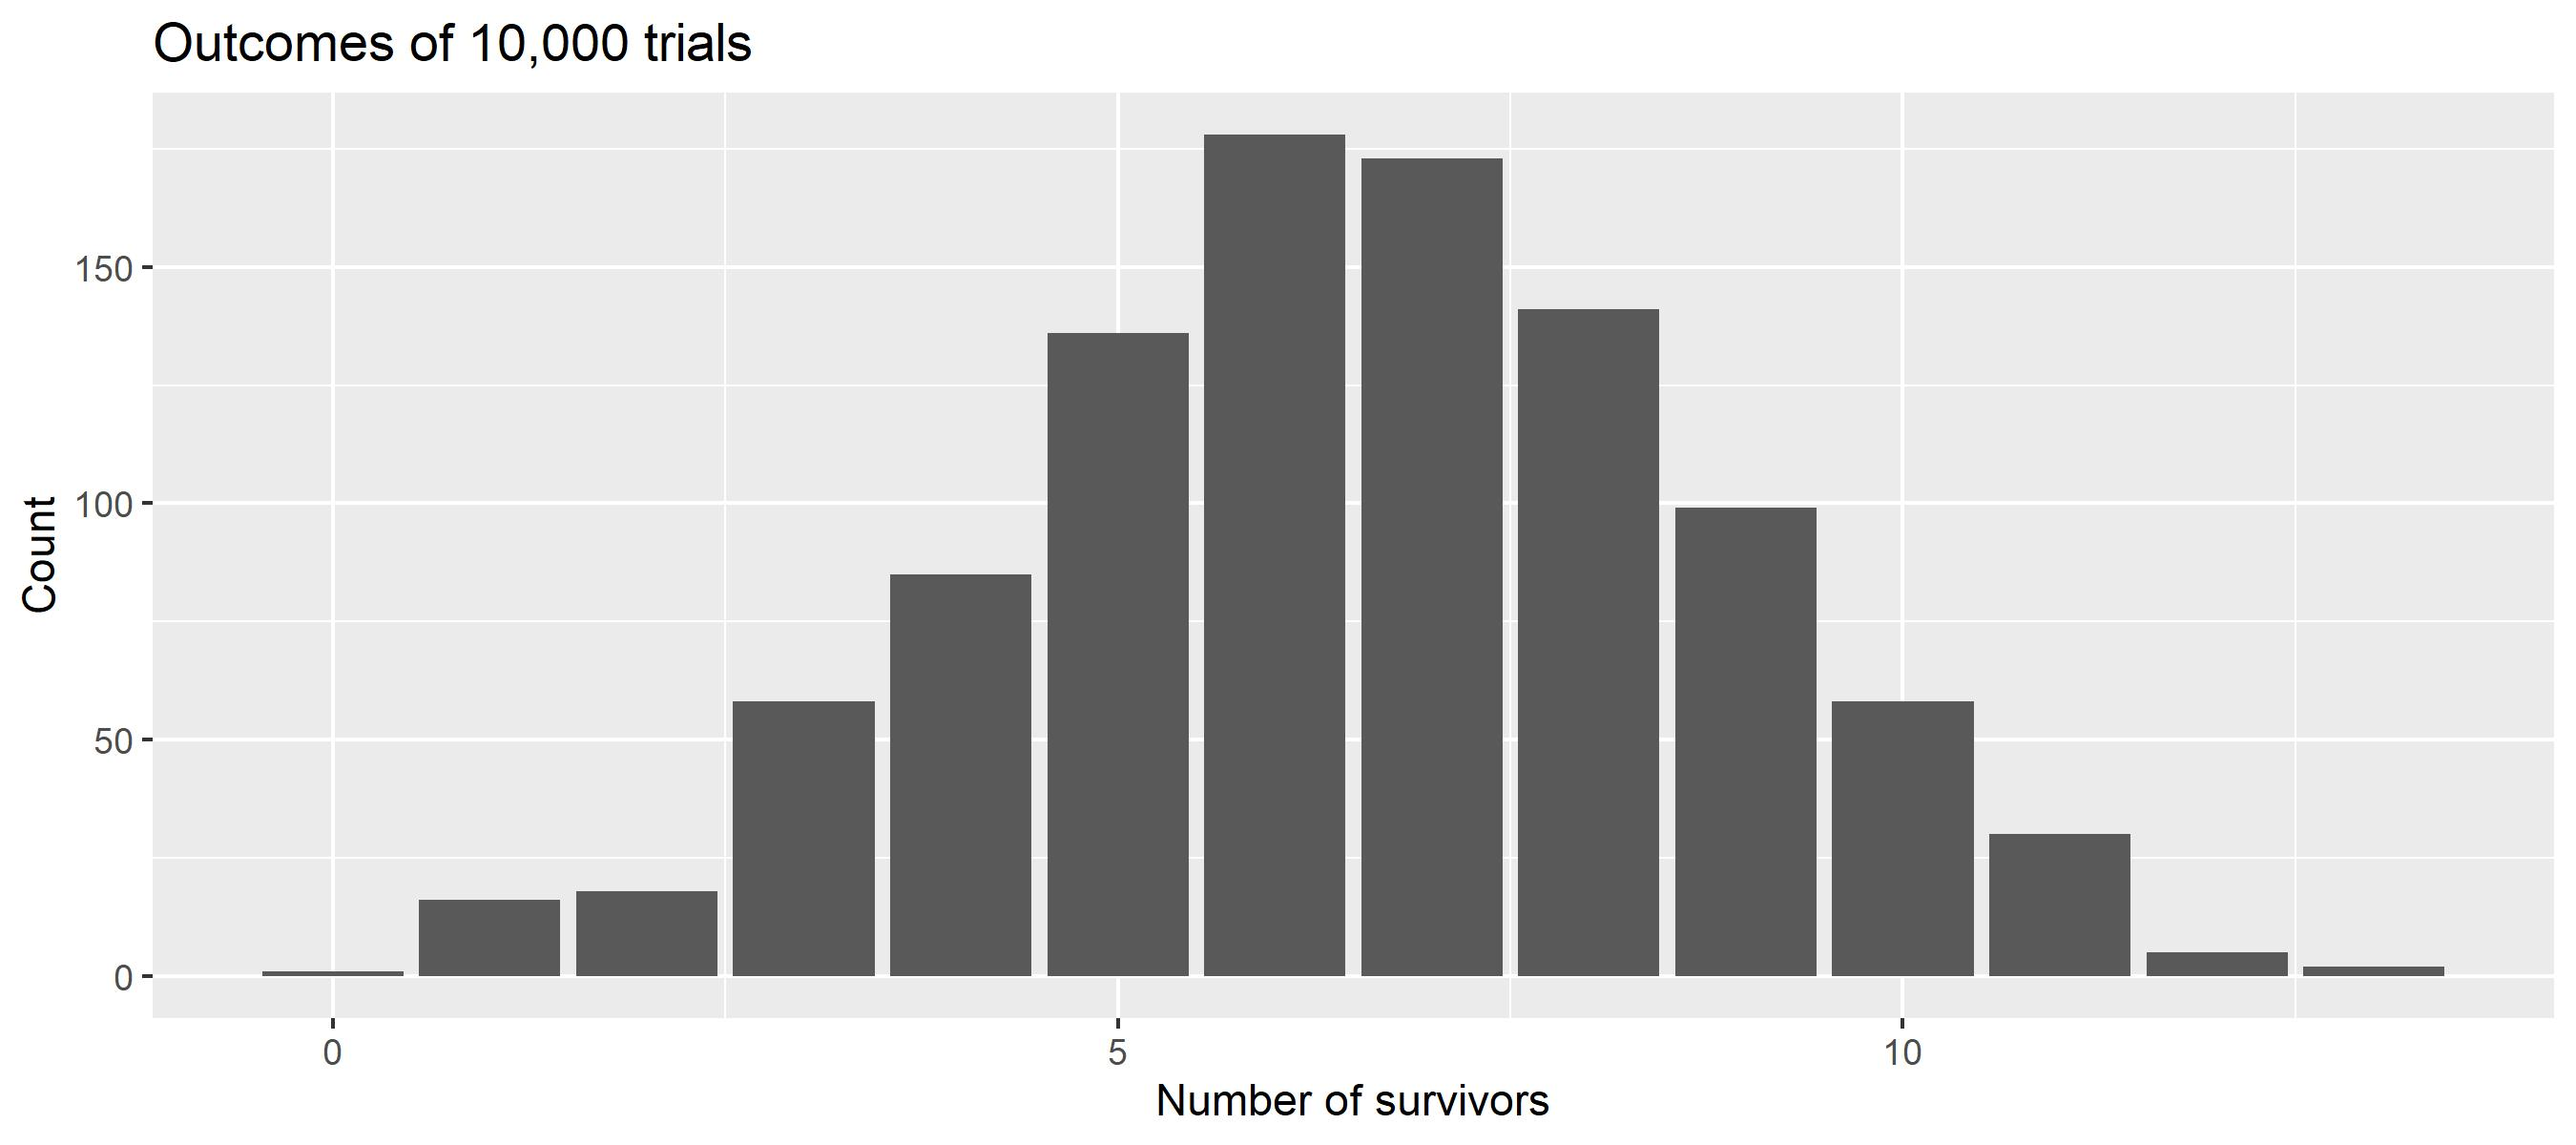

In [88]:
manyGames.plot(x = { numSurvivors }).geomBar().labs(
    title = "Outcomes of 10,000 trials",
    x = "Number of survivors",
    y = "Count"
)


As we learn from the plot, we have a minor zero inflated distribution with an average of around 7. So on average 7 players will survive the game.


To better understand the process, we want to visualize the probability of survival based on the player order number.

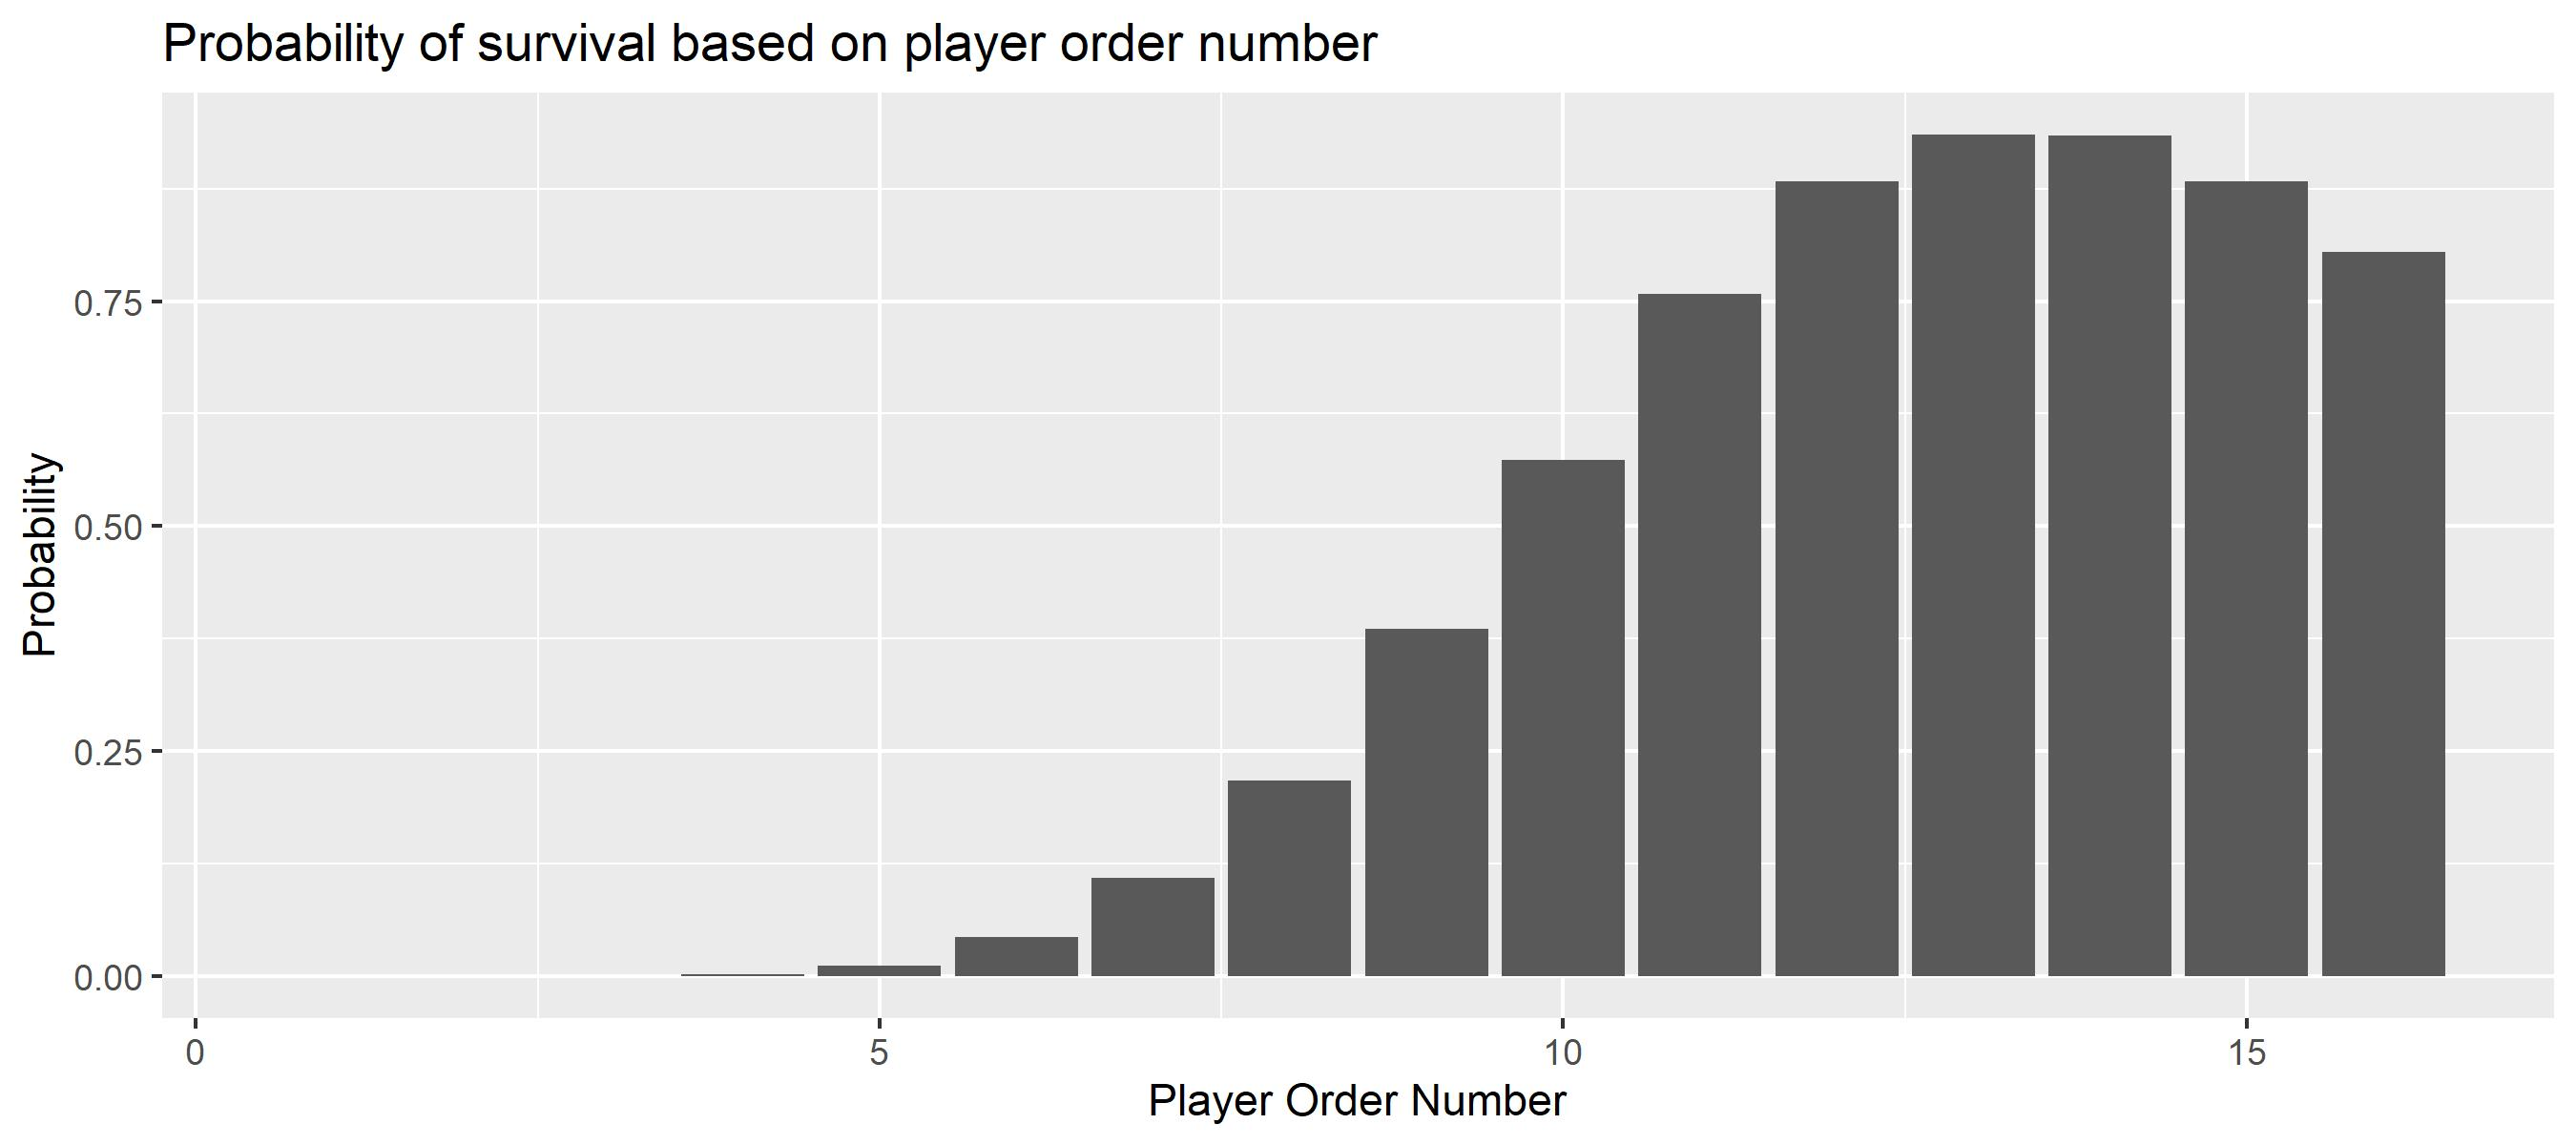

In [89]:
val survivalProbByNo = (1..manyGames.first().numPlayers).map { playerNo ->
    playerNo to manyGames.count { it.playerSurvived(playerNo) }.toDouble() / manyGames.size
}

survivalProbByNo.plot(x = { it.first }, y = { it.second }).geomCol().labs(
    title = "Probability of survival based on player order number",
    x = "Player Order Number",
    y = "Probability"
)

So indeed there seems a strategy to maximize your odds of survival in the game. Simply pick **No13**, and you may live more likely compared to any other starting number.


## Game Continuation in Series

Now, we calculate the probability of having less than two survivors. That's in particular relevant in the series, as the bridge game is not meant to be last game, and at least 2 players are required to continue the games.


In [90]:
val probLT2Players = manyGames.count { it.numSurvivors < 2 }.toDouble() / manyGames.size
println("the probability for less than 2 players is ${probLT2Players}")

println("On average ${avgSurvivors} players will survive the game of squid")


the probability for less than 2 players is 0.017
On average 6.54 players will survive the game of squid


One may wonder why the makes of the series have piced 18 steps and not more or less. What do the number says? What are the odds for game continuation (# survivors >2) when the number of steps is different?

To answer these questions, lets re-run the model while varying the steps. To keep things simple, we run 10,000 iterations of the game over an increasing number of steps from 10 to 30:


In [91]:
val stepSims = (10..30).flatMap { numSteps ->
    org.kalasim.misc.repeat(10000) {
        SquidGame(numSteps = numSteps).apply { run() }
    }
}

val stepSimSummary = stepSims.groupBy { it.numSteps }.map { (steps, games) ->
    steps to games.count { it.numSurvivors < 2 }.toDouble() / games.size
}

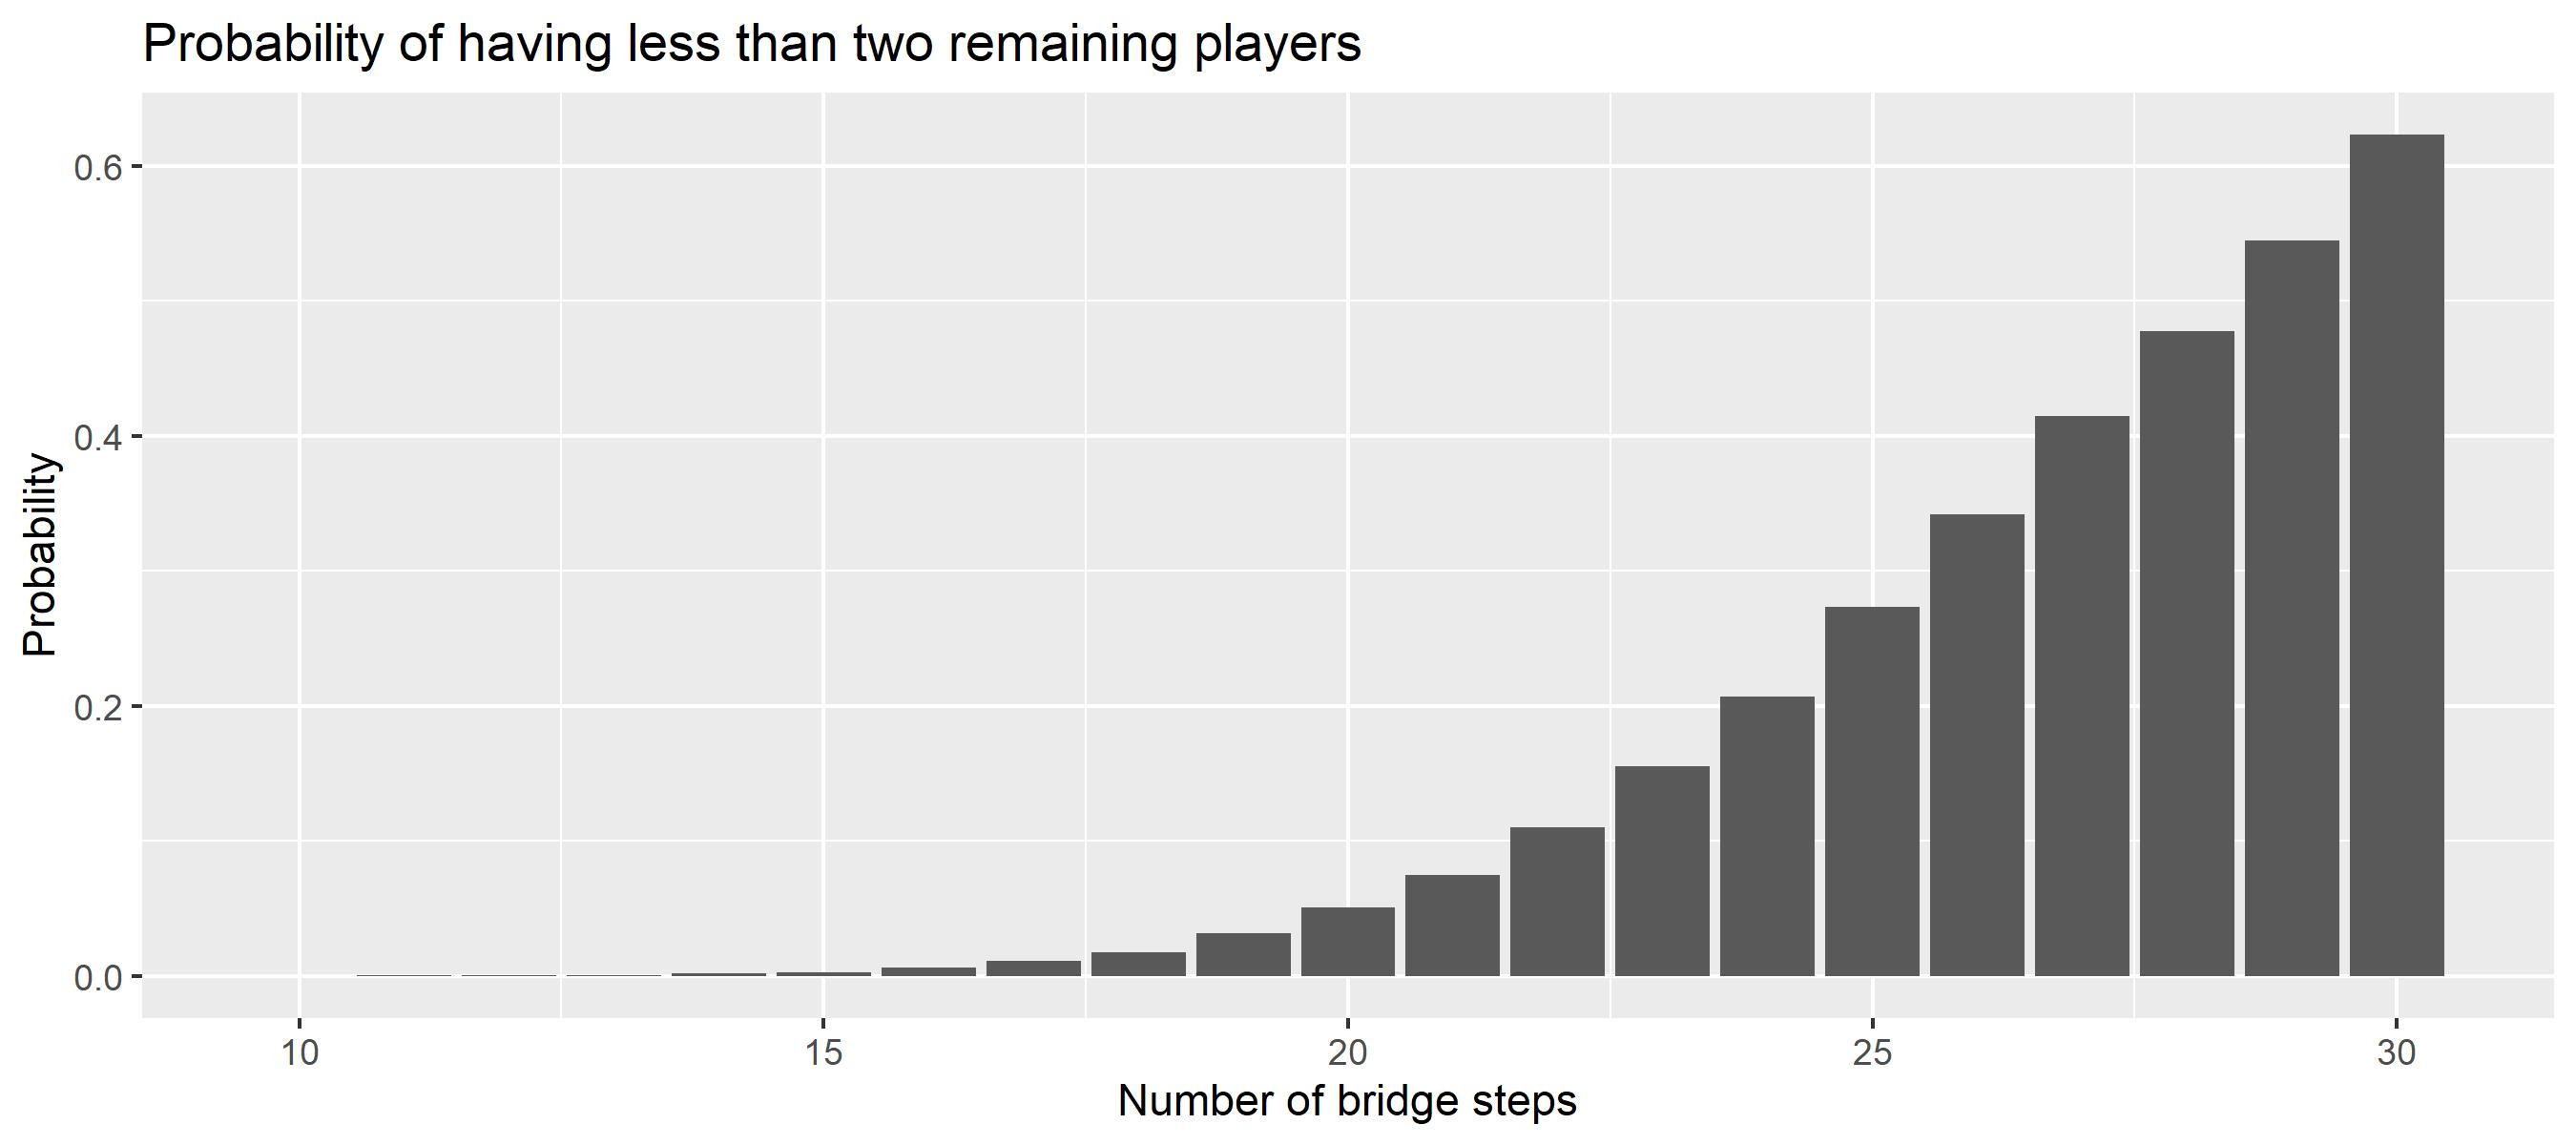

In [92]:
stepSimSummary.plot(x = { it.first }, y = { it.second }).geomCol().labs(
    title = "Probability of having less than two remaining players",
    x = "Number of bridge steps",
    y = "Probability"
)

With more than 16 steps, the odds of having more than 2 players decay quickly.

That's it for the example. And be reminded, if you ever find a card on your doorstep in times of despair with in invite to a suid-like game, trash it, smoke it or eat it.

For complete sources, also see the jupyter [notebook](https://nbviewer.org/github/holgerbrandl/kalasim/blob/master/docs/userguide/docs/examples/bridge_game.ipynb). Feel welcome to [get in touch](../index.md#support) for support, suggestions and questions.
Complete source.